### Things we have to import

In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

import prism
import plot_functions as plf

### Extract model from modem file

In [2]:
with open("modem_model") as file:
    
    # ignore 1st line with '#'
    line = file.readline().split()
    # read 2nd line and convert nx, ny and nz values to int
    line = file.readline().split()
    nx = int(line[0])
    ny = int(line[1])
    nz = int(line[2])
    # read 3rd line and convert dx values to numpy.array 1d
    line = file.readline().split()
    dx = np.array(line, dtype='float')
    # read 4th line and convert dy values to numpy.array 1d
    line = file.readline().split()
    dy = np.array(line, dtype='float')
    # read 5th line and convert dz values to numpy.array 1d
    line = file.readline().split()
    dz = np.array(line, dtype='float')
    
    # read empty line
    line = file.readline().split()
    
    # iterate over the model to get the resistivities
    res = []
    for k in range(nz):
        for j in range(ny):
            # read line with resistivity values at constant z and y
            line = file.readline().split()
            # convert value to float
            line = list(map(float, line))
            # append converted line to list 'res'
            res.append(line)
        # read empty line
        line = file.readline().split()

    # convert resistivities values to numpy array 1d
    res = np.hstack(res)
    
    # read x0 and y0 values
    x0 = float(line[0])
    y0 = float(line[1])
    z0 = 0.0

### Create the model geometry

In [3]:
# define the edge locations
x = x0 + np.hstack([0., np.cumsum(dx)])
y = y0 + np.hstack([0., np.cumsum(dy)])
z = z0 + np.hstack([0., np.cumsum(dz)])

In [4]:
# iterate over the edge locations to create the model
model = []
for z1, z2 in zip(z[0:-1:1], z[1::1]):
    for y1, y2 in zip(y[0:-1:1], y[1::1]):
        for x1, x2 in zip(x[0:-1:1], x[1::1]):
            model.append([y1, y2, x1, x2, z1, z2])
model = np.vstack(model)

In [5]:
model.shape

(18000, 6)

In [6]:
print(model[:10])

[[-10880.     -9023.535 -10880.     -9023.535      0.        50.   ]
 [-10880.     -9023.535  -9023.535  -7595.485      0.        50.   ]
 [-10880.     -9023.535  -7595.485  -6496.985      0.        50.   ]
 [-10880.     -9023.535  -6496.985  -5651.985      0.        50.   ]
 [-10880.     -9023.535  -5651.985  -5001.985      0.        50.   ]
 [-10880.     -9023.535  -5001.985  -4501.985      0.        50.   ]
 [-10880.     -9023.535  -4501.985  -4001.985      0.        50.   ]
 [-10880.     -9023.535  -4001.985  -3501.985      0.        50.   ]
 [-10880.     -9023.535  -3501.985  -3001.985      0.        50.   ]
 [-10880.     -9023.535  -3001.985  -2501.985      0.        50.   ]]


### Convert resistivities to densities

In [7]:
# simple function just for testing
dens = 1*res

In [8]:
print(res[200:221])

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100.]


In [9]:
print(dens[200:221])

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100.]


### Create the computation points

For convenience, the computation points are created at the center of the prisms, at $z = 0$.

In [10]:
# number of prisms along x and y
shape = (nx, ny)

In [11]:
# minimum x, maximum x, minimum y and maximum y
area = [np.min(x)+0.5*dx[0], np.max(x)-0.5*dx[-1], 
        np.min(y)+0.5*dy[0], np.max(y)-0.5*dy[-1]]

In [12]:
# define the coordinates
xp = x[0:-1:1] + 0.5*dx
yp = y[0:-1:1] + 0.5*dy

xp, yp = np.meshgrid(xp, yp)

xp = np.ravel(xp)
yp = np.ravel(yp)
zp = np.zeros_like(xp) - 0.

coordinates = np.vstack([yp, xp, zp])

### Synthetic gravity disturbance (in mGal)

In [13]:
# Compute the vertical component of acceleration
gz = prism.grav(coordinates=coordinates, 
                prisms=model, 
                density=dens, 
                field='g_z')

### Plot the computed gravity disturbance

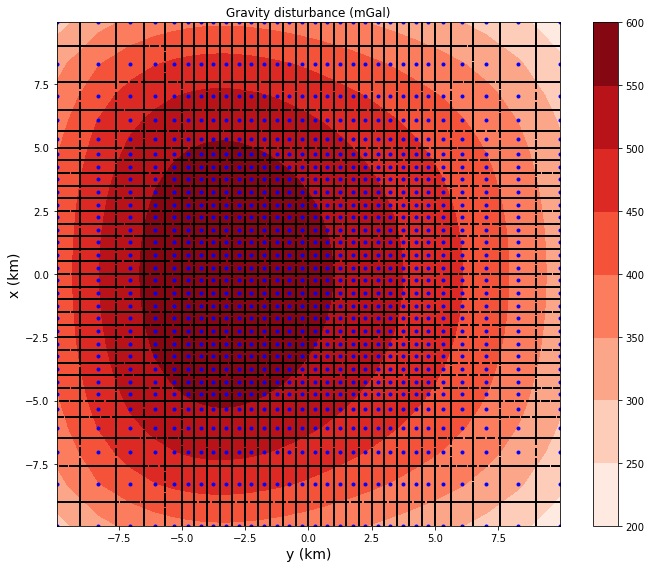

In [14]:
plt.figure(figsize=(10,8))

plt.title("Gravity disturbance (mGal)")
plt.axis('scaled')

# gravity disturbance map
plt.contourf(yp.reshape(shape)*0.001, 
             xp.reshape(shape)*0.001, 
             gz.reshape(shape), cmap='Reds')
plt.colorbar()

# boundaries of the prisms
plf.model_boundaries(model, m2km=True)

# computation points
plt.plot(yp.ravel()*0.001, xp.ravel()*0.001, 'b.')

plt.xlim(0.001*area[0], 0.001*area[1])
plt.ylim(0.001*area[2], 0.001*area[3])
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)

plt.tight_layout()

plt.show()